In [8]:
#export 
from exp.nb_02 import * 
import torch.nn.functional as F 
from torch import nn 

In [9]:
x_train,y_train,x_valid,y_valid = get_data()

In [10]:
n,m = x_train.shape
c = y_train.max() + 1
nh = 50 

In [17]:
class Model(nn.Module):
    def __init__(self,n_in,nh,n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh),nn.ReLU(),nn.Linear(nh,n_out)]
        
    def __call__(self,x):
        for l in self.layers: x = l(x)
        return x 

In [18]:
model = Model(m,nh,10)

In [19]:
model

Model()

In [20]:
pred = model(x_train)

## Cross Entropy Loss 



First, we will need to compute the softmax of our activations. This is defined by:
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$

In practice, we will need the log of the softmax when we calculate the loss.


In [21]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [22]:
sm_pred = log_softmax(pred)



The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:
$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded, this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style integer array indexing. Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.


In [40]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [56]:
loss = nll(sm_pred, torch.FloatTensor([y_train]))

ValueError: only one element tensors can be converted to Python scalars

In [54]:
y_train

tensor([5., 0., 4.,  ..., 5., 6., 8.])

In [55]:
sm_pred[list(range(y_train.shape[0])),list(y_train)].mean()

TypeError: only integer tensors of a single element can be converted to an index

In [51]:
x = torch.randn(10,10)

In [52]:
x[[0,1],[1,2]]

tensor([-0.9746,  0.3554])

In [57]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()



Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the LogSumExp trick. The idea is to use the following formula:
$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.


In [58]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [59]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [67]:
loss = F.nll_loss(F.log_softmax(pred.type(torch.FloatTensor), -1), y_train.type(torch.LongTensor))

In [70]:
test_near(F.cross_entropy(pred, y_train.type(torch.LongTensor)), loss)

In [76]:
y_train = y_train.type(torch.LongTensor)


## Basic training loop

Basically the training loop repeats over the following steps:

    get the output of the model on a batch of inputs
    compare the output to the labels we have and compute a loss
    calculate the gradients of the loss with respect to every parameter of the model
    update said parameters with those gradients to make them a little bit better



In [77]:
loss_func = F.cross_entropy

In [78]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()


In [92]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.0299,  0.0616,  0.0469,  0.0350, -0.0262, -0.0944,  0.0284,  0.0769,
         -0.0366, -0.0171], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [93]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3024, grad_fn=<NllLossBackward>)

In [94]:
accuracy(preds, yb)

tensor(0.0781)

In [119]:
lr = 0.01   # learning rate
epochs = 30 # how many epochs to train for

In [111]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()


In [112]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(2.3048, grad_fn=<NllLossBackward>), tensor(0.0938))


## Using parameters and optim¶


In [113]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [114]:
model = Model(m, nh, 10)

In [115]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [116]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [117]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [120]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(1.8792, grad_fn=<NllLossBackward>), tensor(0.2188))

In [121]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [122]:

mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [123]:

[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering Modules

In [124]:

layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [125]:



class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x



In [126]:

model = Model(layers)

In [127]:

model


Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## Sequential Module

In [128]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [129]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(1.7908, grad_fn=<NllLossBackward>), tensor(0.2188))

In [132]:
nh

50

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [133]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [134]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [135]:
opt = Optimizer(model.parameters())

In [136]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [137]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(2.2983, grad_fn=<NllLossBackward>), tensor(0.0625))

In [138]:
#export
from torch import optim

In [139]:
optim.SGD.step??

In [140]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [141]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(27.8620, grad_fn=<NllLossBackward>)

In [142]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [143]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(1.8842, grad_fn=<NllLossBackward>), tensor(0.2500))

#  Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [144]:
#export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [145]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [146]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [147]:
model,opt = get_model()

In [148]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [149]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
# assert acc>0.7
loss,acc

(tensor(1.6544, grad_fn=<NllLossBackward>), tensor(0.3125))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [150]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [151]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [152]:
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(7.)

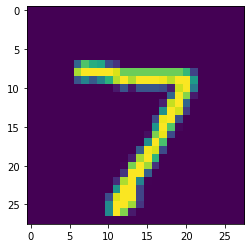

In [153]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [154]:
model,opt = get_model()

In [155]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [157]:
loss,acc = loss_func(model(xb), yb.type(torch.LongTensor)), accuracy(model(xb), yb)
# assert acc>0.7
loss,acc

(tensor(18.1562, grad_fn=<NllLossBackward>), tensor(0.1406))